In [1]:
import scipy.io
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

def apply_kpca_to_hyperspectral_image(hyperspectral_image, n_components):
    # Get the shape of the input data
    width, height, num_channels = hyperspectral_image.shape

    # Reshape the data to (num_samples, num_features)
    reshaped_data = hyperspectral_image.reshape(-1, num_channels)

    # Standardize the data
    scaler = StandardScaler()
    reshaped_data = scaler.fit_transform(reshaped_data)

    # Apply Kernel PCA with Radial Basis Function (RBF) kernel
    kpca = KernelPCA(n_components=n_components, kernel='rbf')
    transformed_data = kpca.fit_transform(reshaped_data)
    eigenvalues = kpca.eigenvalues_

    # Calculate the explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    op=0
    # Print explained variance ratio for each component
    for i, ratio in enumerate(explained_variance_ratio):
        op+=ratio
    print(f"variance covered {op:.2f}")
    # Reshape the data back to 3D form
    transformed_data = transformed_data.reshape(width, height, n_components)
    
    return transformed_data, explained_variance_ratio




In [3]:
def extract_patches(image, patch_size=(64, 64)):
    patches = []
    height, width, _ = image.shape
    patch_height, patch_width = patch_size

    for i in range(0, height, patch_height):
        for j in range(0, width, patch_width):
            # Extract the patch
            patch = image[i:i + patch_height, j:j + patch_width, :]

            # Check if the patch matches the desired shape
            if patch.shape == (patch_height, patch_width, _):
                patches.append(patch)

    return patches

In [4]:
import os
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
      #  self.target_size = target_size
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.folder_path, file_name)
        
        # Load the .mat file
        mat_data = scipy.io.loadmat(file_path)
        image_data = mat_data['img']
        
        # Apply preprocessing: pad and normalize
#         padded_image = pad_image(image_data, self.target_size)
        normalized_image = normalize_image(image_data)

        # Convert to PyTorch tensor
        image_tensor = torch.from_numpy(normalized_image).float()

        return image_tensor

def pad_image(image, target_size):
    """
    Pads the input image to the target size.

    Parameters:
    image (numpy.ndarray): The input image array.
    target_size (tuple): The desired output size (height, width, channels).

    Returns:
    numpy.ndarray: The padded image array.
    """
    padded_image = np.zeros(target_size, dtype=image.dtype)
    current_size = image.shape

    # Calculate the padding for height and width
    pad_height = (target_size[0] - current_size[0]) // 2
    pad_width = (target_size[1] - current_size[1]) // 2
    
    # Place the image in the center of the padded array
    padded_image[pad_height:pad_height + current_size[0], pad_width:pad_width + current_size[1], :current_size[2]] = image

    return padded_image

def normalize_image(image):
    """
    Normalizes the image to the range [0, 1].

    Parameters:
    image (numpy.ndarray): The input image array.

    Returns:
    numpy.ndarray: The normalized image array.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)


In [5]:
folder_path = "/kaggle/input/sih2024-dataset"
target_size = (2100, 700, 224)

# Create the dataset and dataloader
dataset = CustomImageDataset(folder_path=folder_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False,num_workers=0)

for batch in dataloader:
    print(batch.shape)

torch.Size([1, 1175, 563, 224])
torch.Size([1, 1386, 690, 224])
torch.Size([1, 1965, 492, 224])
torch.Size([1, 1185, 682, 224])
torch.Size([1, 1466, 676, 224])
torch.Size([1, 1033, 437, 224])
torch.Size([1, 600, 400, 224])
torch.Size([1, 1569, 517, 224])
torch.Size([1, 2088, 691, 224])
torch.Size([1, 842, 640, 224])
torch.Size([1, 1243, 684, 224])
torch.Size([1, 836, 572, 224])
torch.Size([1, 1786, 699, 224])
torch.Size([1, 1532, 567, 224])
torch.Size([1, 1260, 523, 224])
torch.Size([1, 1342, 527, 224])
torch.Size([1, 2085, 682, 224])
torch.Size([1, 1084, 680, 224])


In [6]:
class PatchDataset(Dataset):
    def __init__(self, patches):
        """
        Args:
            patches (list): A list of image patches.
        """
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [7]:
import cv2
import numpy as np

def apply_laplacian(band):
    """Apply Laplacian operator to a single band."""
    # Convert the band to uint8 if it's not already
    if band.dtype != np.uint8:
        band = cv2.normalize(band, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Ensure the band is 2D
    if len(band.shape) == 3 and band.shape[2] == 1:
        band = band[:, :, 0]
    elif len(band.shape) > 2:
        raise ValueError("Input band must be a 2D array or 3D with a single channel.")
    # Apply the Laplacian filter
    return cv2.Laplacian(band, cv2.CV_64F)

def calculate_noise_variance(hyperspectral_image):
    """Calculate noise variance for each spectral band."""
    IW, IH, IN = hyperspectral_image.shape
    noise_variances = []
    
    for n in range(IN):
        band = hyperspectral_image[:, :, n]
        laplacian_band = apply_laplacian(band)
        mean_band = np.mean(laplacian_band)
        noise_variance = np.sum((laplacian_band - mean_band) ** 2) / (6 * (IW - 2) * (IH - 2))
        noise_variances.append(noise_variance)
    
    return np.array(noise_variances)

def select_bands(hyperspectral_image):
    """Select spectral bands with noise variance below the threshold."""
    noise_variances = calculate_noise_variance(hyperspectral_image)
    IN = hyperspectral_image.shape[2]
    
    # Calculate the threshold
    threshold = np.sum(noise_variances) / (2 * IN)
    
    selected_bands = []
    for n in range(IN):
        if noise_variances[n] < threshold:
            selected_bands.append(hyperspectral_image[:, :, n])
    
    if len(selected_bands) == 0:
        return None  # or return an empty array if that's more appropriate
    else:
        return np.stack(selected_bands, axis=2)
big_patch=[]
for batch in dataloader:
    
    filtered_image = select_bands(np.array(batch[0]))
    filtered_image=extract_patches(filtered_image)
    big_patch.append(filtered_image)
    print(len(filtered_image))
    
    
# Example usage with a dataloader

144
210
210
180
220
96
54
192
320
130
190
104
270
184
152
160
320
160


In [8]:
patch_dataset = PatchDataset(big_patch)

patch_dataloader = DataLoader(patch_dataset, batch_size=1, shuffle=False) 



In [13]:
del big_patch

In [14]:
n_components=14
big_patch=[]
i=0
for batch in patch_dataloader:
    patchs=[]
    for patch in batch:
        patch,_ =apply_kpca_to_hyperspectral_image(patch[0], n_components)
        print(patch.shape)
        patchs.append(patch)
    i+=1
    print(f"batch {i} done")
    big_patch.append(patchs)
    if i==5:
        break

variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.00
(64, 64, 14)
variance covered 1.0

In [15]:
patch_dataset = PatchDataset(big_patch)

patch_dataloader = DataLoader(patch_dataset, batch_size=1, shuffle=False) 

In [20]:
patch_dataset1=patch_dataset
patch_dataloader1=patch_dataloader

In [25]:
torch.save(patch_dataset, 'dataset_data.pt')


In [ ]:
print("hello world")

In [ ]:
import os
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
class PatchDataset(Dataset):
    def __init__(self, patches):
        """
        Args:
            patches (list): A list of image patches.
        """
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [ ]:
for batch in patch_dataloader:
    for patch in batch:
        
    

In [19]:
oi=0
for batch in patch_dataloader:
    for patch in batch:
        oi+=1
print(oi)

964


In [ ]:
Ih = target_size[0]
Iw = target_size[1]
In = target_size[2]




In [26]:
data12 = torch.load('dataset_data.pt')

In [30]:
dataset12=PatchDataset(data12)
dataloader12 = DataLoader(dataset12)

In [34]:
lit=[]
for batch in patch_dataloader:
    for patch in batch:
        lit.append(patch)
        
lit=np.array(lit)

In [35]:
lit.shape

(964, 1, 64, 64, 14)

In [38]:
lit= np.squeeze(lit)


In [72]:
reshaped_data = lit.reshape(-1, 14)
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
isolation_forest = IsolationForest(n_estimators=500, contamination='auto', random_state=42)

# Fit the model to the reshaped data
isolation_forest.fit(reshaped_data)

# Predict anomalies (1 for normal, -1 for anomaly)
predictions = isolation_forest.predict(reshaped_data)

# Optionally, get anomaly scores (lower score indicates higher chance of being an anomaly)
anomaly_scores = isolation_forest.decision_function(reshaped_data)

In [104]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

# Define the height of the tree for the calculation
def height_of_tree(n_samples):
    return np.log2(n_samples)

# Compute path length for each pixel
def calculate_path_length(iso_forest, data):
    # Use decision_function to get anomaly scores
    anomaly_scores = iso_forest.decision_function(data)
    # Convert anomaly scores to path lengths
    path_lengths = -anomaly_scores
    return path_lengths

# Compute the probability of each pixel
def calculate_probability(path_length, n_samples, height):
    # Expected path length c(m)
    c_m = 2 * (np.log(n_samples - 1) + 0.5772156649) - (2 * (n_samples - 1)) / (n_samples - 2)
    prob = 2 ** (-path_length / c_m)
    return prob

# Calculate path lengths
path_lengths = calculate_path_length(isolation_forest, reshaped_data)
n_samples = reshaped_data.shape[0]
height = height_of_tree(n_samples)

# Calculate probabilities
probabilities = np.array([calculate_probability(length, n_samples, height) for length in path_lengths])

# Perform k-means clustering
probabilities = probabilities.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(probabilities)

# Labels will be 0 or 1 based on k-means clustering


In [106]:
probabilities.min()

0.9958286960057363

In [100]:
# from sklearn.cluster import KMeans

# # Reshape probabilities to fit KMeans
# probabilities = probabilities.reshape(-1, 1)

# # Perform k-means clustering
# kmeans = KMeans(n_clusters=2, random_state=42)
# labels = kmeans.fit_predict(probabilities)
labels=labels.reshape(964, 64, 64)

In [93]:
np.unique(labels)

array([0], dtype=int32)

In [73]:
    predictions_reshaped = predictions.reshape(964, 64, 64)

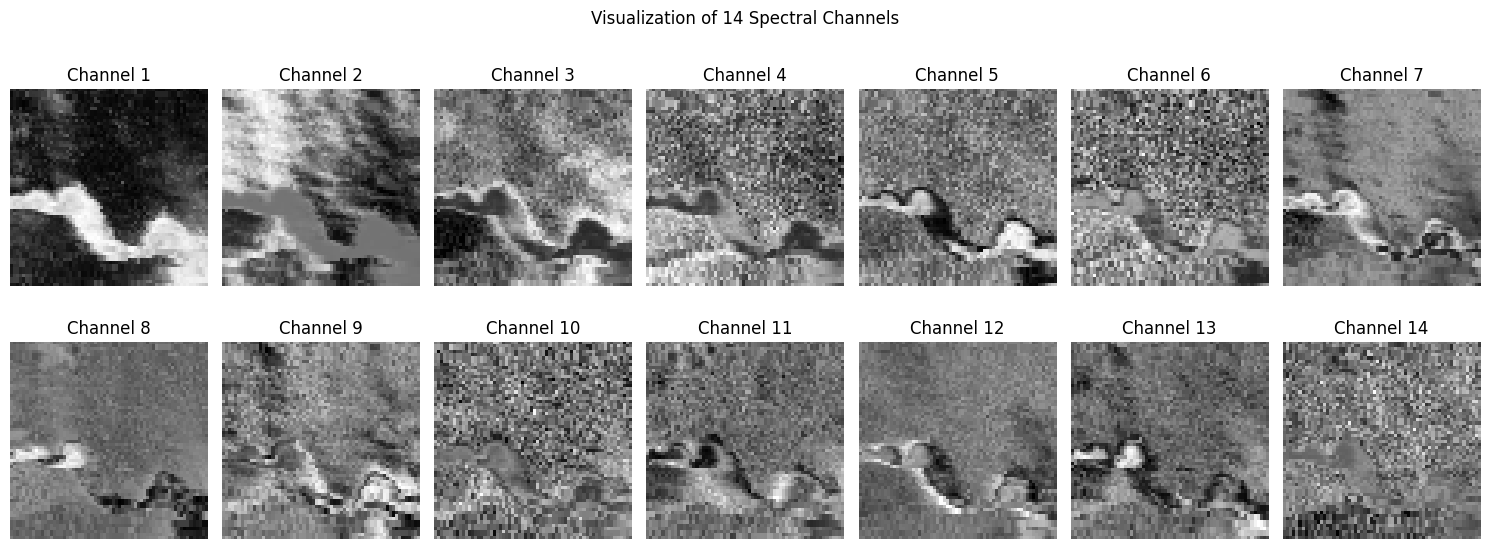

In [135]:
image = lit[ind]  

# Creates a figure with subplots, one for each channel
fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i in range(14):
    ax = axes[i // 7, i % 7]
    ax.imshow(image[:, :, i], cmap='gray')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

plt.suptitle("Visualization of 14 Spectral Channels")
plt.tight_layout()
plt.show()

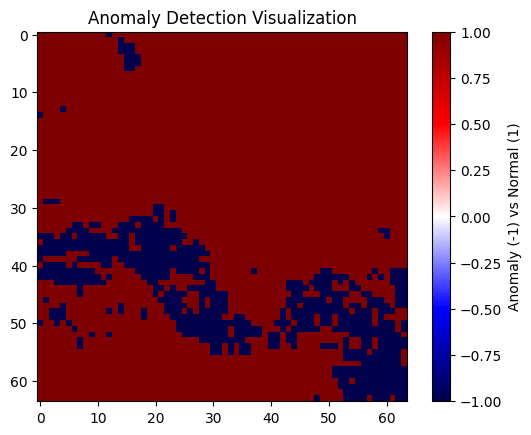

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions_reshaped[0]' is a (64, 64) array of 1 and -1
anomaly_map = predictions_reshaped[ind]

# Define the colormap: 'seismic' shows red for negative and blue for positive values
plt.imshow(anomaly_map, cmap='seismic', interpolation='none')

# Add a color bar for reference
plt.colorbar(label='Anomaly (-1) vs Normal (1)')

# Add a title
plt.title("Anomaly Detection Visualization")


# Show the plot
plt.show()

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize

# Define the adjacency function for a 2D grid
def is_adjacent(i, j, shape):
    rows, cols = shape[1], shape[2]
    i_row, i_col = divmod(i, cols)
    j_row, j_col = divmod(j, cols)
    return abs(i_row - j_row) + abs(i_col - j_col) == 1

# Compute the Laplacian matrix
def compute_laplacian_matrix(prob_map, beta):
    n = prob_map.size
    L = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j and is_adjacent(i, j, prob_map.shape):
                L[i, j] = np.exp(-beta * (prob_map.flatten()[i] - prob_map.flatten()[j]) ** 2)
    
    np.fill_diagonal(L, np.sum(L, axis=1))
    return L

# Objective function for ERW refinement
def objective_function(prob_map_flat, L, alpha, beta, initial_prob_map_flat):
    prob_map = prob_map_flat.reshape(initial_prob_map_flat.shape)
    spatial_term = np.dot(prob_map_flat.T, np.dot(L, prob_map_flat))
    aspatial_term = np.sum((prob_map_flat - initial_prob_map_flat) ** 2)
    return alpha * spatial_term + beta * aspatial_term

# Load your data
# Example data loading (replace with actual data loading)
training_data = np.random.rand(963 * 64 * 64, 14)  # Replace with actual training data
training_labels = np.random.randint(0, 2, (963 * 64 * 64,))  # Replace with actual labels
dimension_reduced_data = np.random.rand(963 * 64 * 64, 14)  # Replace with actual dimension-reduced data

# Step 1: Initial Classification with SVM
Tr = np.reshape(training_data, (-1, 14))  # Shape: (963*64*64, 14)
labels = np.reshape(training_labels, (-1,))  # Shape: (963*64*64,)

# Preprocessing and SVM classification
scaler = StandardScaler()
pipeline = make_pipeline(scaler, SVC(kernel='rbf', probability=True, random_state=42))
pipeline.fit(Tr, labels)

# Predict probabilities on the dimension-reduced data Y
Y = np.reshape(dimension_reduced_data, (-1, 14))  # Ensure Y has the same feature dimension
probabilities = pipeline.predict_proba(Y)[:, 1]  # Get probability for class 1

# Reshape probabilities to match the original dimensions
initial_prob_map = np.reshape(probabilities, (963, 64, 64))

# Step 2: Refine with ERW Method

# Parameters for the ERW method
alpha = 1e-5
beta = 7.0

# Flatten initial probability map for optimization
initial_prob_map_flat = initial_prob_map.flatten()

# Compute Laplacian matrix
L = compute_laplacian_matrix(initial_prob_map, beta)

# Optimize
result = minimize(objective_function, initial_prob_map_flat, args=(L, alpha, beta, initial_prob_map_flat), method='BFGS')

# Reshape refined probability map
refined_prob_map = result.x.reshape(963, 64, 64)

# `refined_prob_map` now contains the refined probability map after applying ERW


In [80]:
np.unique(predictions,return_counts=True)

(array([-1,  1]), array([ 269878, 3678666]))